In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# 1. Data Preprocessing

In [41]:
# Load Dataset
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/COVID-19%20Coronavirus%20(2).csv"
df = pd.read_csv(url)

# Basic Preprocessing
# Remove duplicates and missing values
df = df.drop_duplicates()
df = df.dropna()

# Clean column names (remove extra spaces)
df.columns = [c.strip() for c in df.columns]

print("Data loaded and cleaned.")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Data loaded and cleaned.
Shape: (224, 10)
Columns: ['Country', 'Other names', 'ISO 3166-1 alpha-3 CODE', 'Population', 'Continent', 'Total Cases', 'Total Deaths', 'Tot\xa0Cases//1M pop', 'Tot\xa0Deaths/1M pop', 'Death percentage']


# 2. EDA


Explanation 1:
This map groups countries by their Continent, providing a clear color-coded legend for each region. 
By hovering over specific countries, you can still observe the specific COVID-19 severity metrics (Deaths per 1M and Total Cases).



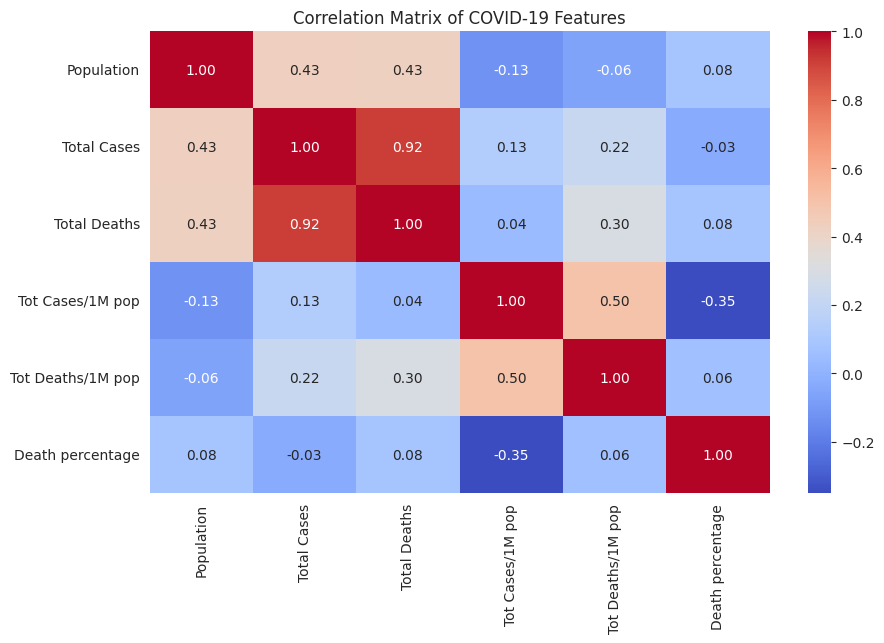


Explanation 2:
The correlation matrix validates relationships between variables, such as the strong link between Total Cases and Total Deaths, helping to select the right features for clustering.



In [42]:
# --- Part 2: Exploratory Data Analysis (EDA) ---

# 1. Clean Column Names (Critical step to fix the previous error)
df.columns = [c.replace('\xa0', ' ').replace('//', '/').strip() for c in df.columns]

# 2. World Map with Continent Legend
# We color by 'Continent' to get the specific legend you asked for.
# We include the death/case stats in 'hover_data' so you can still see the data.
fig = px.choropleth(
    df,
    locations="Country",
    locationmode='country names',
    color="Continent",  # <--- This creates the Legend for each Continent
    hover_name="Country",
    hover_data=["Tot Deaths/1M pop", "Total Cases"], # Keep data visible on hover
    projection="natural earth",
    title="World Map by Continent (with COVID-19 Data on Hover)"
)

# Aesthetic updates
fig.update_geos(showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="#f0f0f0")
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

print("""
Explanation 1:
This map groups countries by their Continent, providing a clear color-coded legend for each region.
By hovering over specific countries, you can still observe the specific COVID-19 severity metrics (Deaths per 1M and Total Cases).
""")

# 3. Correlation Matrix (Unchanged)
numeric_df = df.select_dtypes(include=np.number)
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of COVID-19 Features')
plt.show()

print("""
Explanation 2:
The correlation matrix validates relationships between variables, such as the strong link between Total Cases and Total Deaths, helping to select the right features for clustering.
""")

# 3. Encoding and Data Transformation

In [43]:
# We only handle Encoding here. Feature selection happens in Part 4.
if 'Continent' in df.columns:
    le = LabelEncoder()
    # We create a new column so we don't lose the original text for visualizations later
    df['Continent_Encoded'] = le.fit_transform(df['Continent'])
    print("Encoded 'Continent' to numbers.")
else:
    print("Column 'Continent' not found.")

Encoded 'Continent' to numbers.


# 4. Build Clustering Models (K-Means & Hierarchical)

Features selected: ['Population', 'Continent_Encoded', 'Total Cases', 'Total Deaths', 'Tot Cases/1M pop', 'Tot Deaths/1M pop', 'Death percentage']


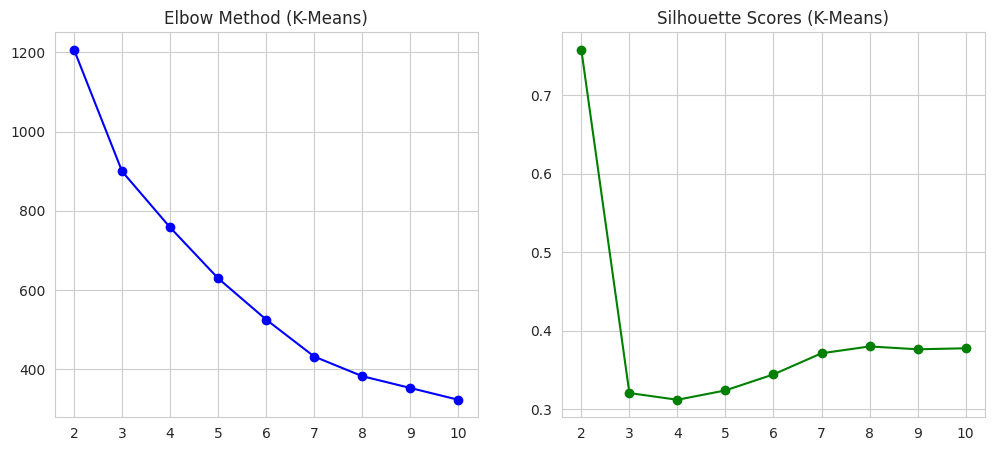

Best K for K-Means: 2


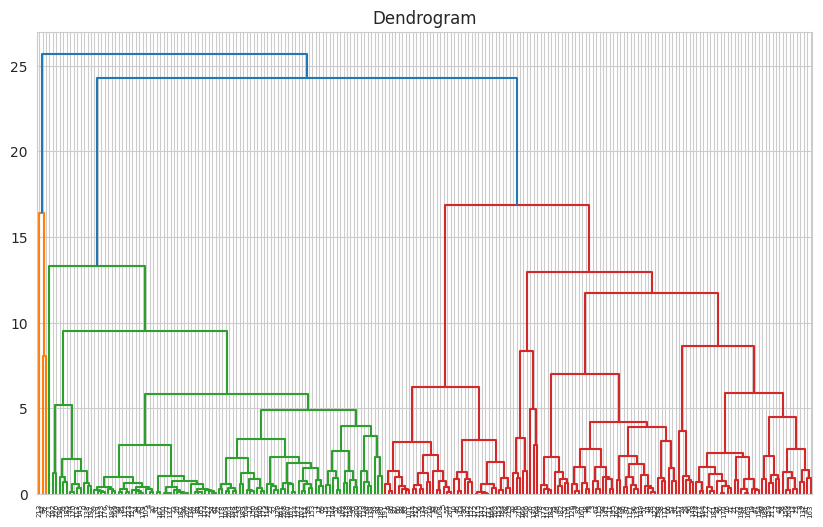

Best K for Hierarchical: 2
--- Part 4 Complete: Models Built ---


In [44]:
# 1. Define Columns for Clustering (As requested)
# Note: We use the Encoded Continent
cluster_cols = [
    'Population', 'Continent_Encoded', 'Total Cases', 'Total Deaths',
    'Tot Cases/1M pop', 'Tot Deaths/1M pop', 'Death percentage'
]

# Verify columns exist
missing = [c for c in cluster_cols if c not in df.columns]
if missing:
    print(f"Error: Missing columns {missing}. Check column names.")
else:
    print(f"Features selected: {cluster_cols}")

# 2. Create Feature Matrix and Scale
X = df[cluster_cols].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Find Best K for K-Means (Elbow & Silhouette)
wcss = []
silhouette_scores_km = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores_km.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o', color='blue')
plt.title('Elbow Method (K-Means)')
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores_km, marker='o', color='green')
plt.title('Silhouette Scores (K-Means)')
plt.show()

# Select Best K (K-Means)
best_k_km = K_range[np.argmax(silhouette_scores_km)]
print(f"Best K for K-Means: {best_k_km}")

# Fit K-Means
kmeans_final = KMeans(n_clusters=best_k_km, random_state=42, n_init=10)
df['Cluster_KMeans'] = kmeans_final.fit_predict(X_scaled)


# 4. Hierarchical Clustering
# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title('Dendrogram')
plt.show()

# Find Best K (Hierarchical) - using Silhouette
silhouette_scores_hc = []
for k in K_range:
    hc = AgglomerativeClustering(n_clusters=k, linkage='ward')
    hc.fit(X_scaled)
    silhouette_scores_hc.append(silhouette_score(X_scaled, hc.labels_))

best_k_hc = K_range[np.argmax(silhouette_scores_hc)]
print(f"Best K for Hierarchical: {best_k_hc}")

# Fit Hierarchical
hc_final = AgglomerativeClustering(n_clusters=best_k_hc, linkage='ward')
df['Cluster_HC'] = hc_final.fit_predict(X_scaled)

print("--- Part 4 Complete: Models Built ---")

# 5. Model Evaluation

In [45]:
score_km = silhouette_score(X_scaled, df['Cluster_KMeans'])
score_hc = silhouette_score(X_scaled, df['Cluster_HC'])

print(f"Silhouette Score (K-Means): {score_km:.4f}")
print(f"Silhouette Score (Hierarchical): {score_hc:.4f}")

Silhouette Score (K-Means): 0.7580
Silhouette Score (Hierarchical): 0.7773


# 6. Cluster Profiling, Visualization & Recommendations


FULL REPORT FOR: K-Means Clustering

Cluster Averages:
                  Population   Total Cases   Total Deaths  Tot Cases/1M pop  \
Cluster_KMeans                                                                
0               2.044618e+07  1.528727e+06   18084.577273     136437.595455   
1               8.481708e+08  3.875566e+07  548629.250000     103724.000000   

                Tot Deaths/1M pop  Death percentage  
Cluster_KMeans                                       
0                     1072.718182          1.436940  
1                     1614.250000          1.910476  


<Figure size 1200x600 with 0 Axes>

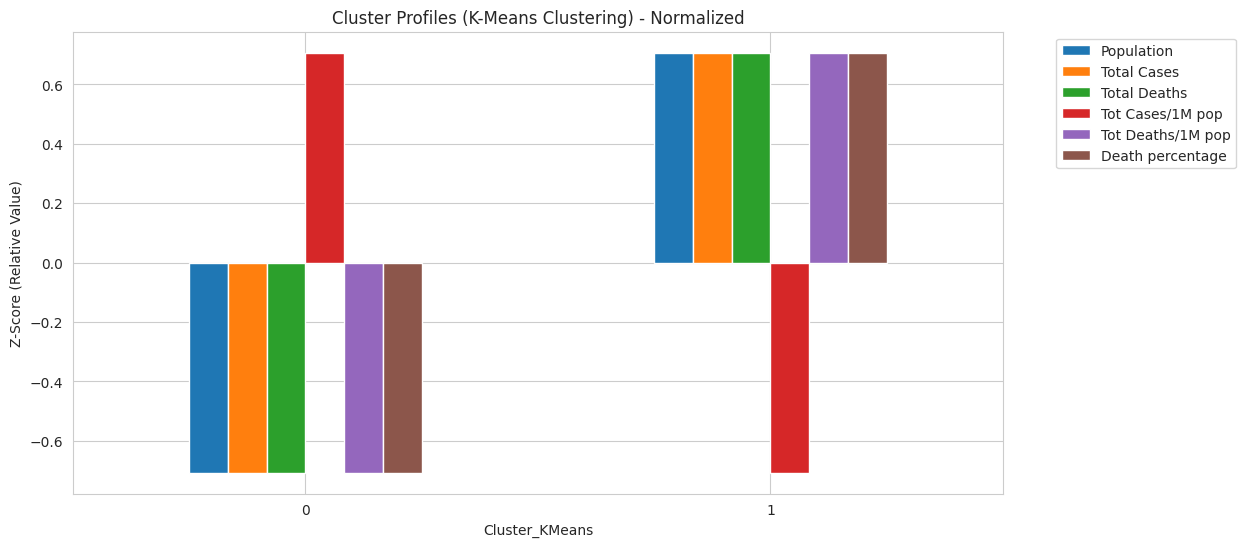


--- Government Policy Recommendations (K-Means Clustering) ---

-------------------- [Cluster 0] --------------------
STATUS: [Moderate Impact / Stabilized Phase]
DIAGNOSIS: Post-peak or controlled transmission. Risk of complacency.

COMPREHENSIVE STRATEGY:
1. Surveillance & Early Warning:
   - Shift to targeted testing (symptomatic & high-risk groups).
   - Implement wastewater surveillance to detect outbreaks early.
   - Allocate resources for genomic sequencing to track variants.

2. Healthcare Capacity:
   - Keep ICU surge capacity on "warm standby".
   - Address healthcare worker burnout with rotation schedules.

3. Vaccination Strategy (The "Ramp Up"):
   - Focus on the "last mile" with mobile units for rural areas.
   - Prepare supply chains for booster shots for the elderly.

4. Economic & Social Protocols:
   - Avoid sudden "Freedom Days"; use tiered reopening based on metrics.
   - Maintain hybrid work incentives to reduce transit density.

5. Communication:
   - Launch camp

<Figure size 1200x600 with 0 Axes>

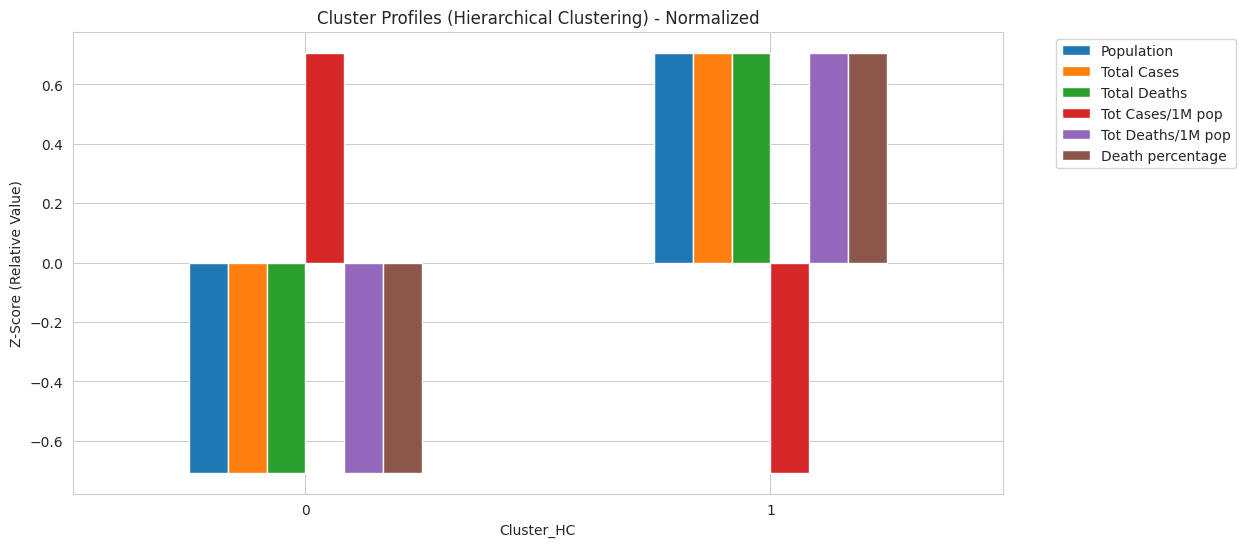


--- Government Policy Recommendations (Hierarchical Clustering) ---

-------------------- [Cluster 0] --------------------
STATUS: [Moderate Impact / Stabilized Phase]
DIAGNOSIS: Post-peak or controlled transmission. Risk of complacency.

COMPREHENSIVE STRATEGY:
1. Surveillance & Early Warning:
   - Shift to targeted testing (symptomatic & high-risk groups).
   - Implement wastewater surveillance to detect outbreaks early.
   - Allocate resources for genomic sequencing to track variants.

2. Healthcare Capacity:
   - Keep ICU surge capacity on "warm standby".
   - Address healthcare worker burnout with rotation schedules.

3. Vaccination Strategy (The "Ramp Up"):
   - Focus on the "last mile" with mobile units for rural areas.
   - Prepare supply chains for booster shots for the elderly.

4. Economic & Social Protocols:
   - Avoid sudden "Freedom Days"; use tiered reopening based on metrics.
   - Maintain hybrid work incentives to reduce transit density.

5. Communication:
   - Launch

In [46]:
# --- Part 6: Cluster Profiling, Visualization & Detailed Recommendations ---

def generate_cluster_report(cluster_col_name, method_name):
    print(f"\n{'='*60}")
    print(f"FULL REPORT FOR: {method_name}")
    print(f"{'='*60}")

    # 1. Cluster Summary (using original numeric values)
    # We use the raw columns to calculate readable averages
    summary_cols = [
        'Population', 'Total Cases', 'Total Deaths',
        'Tot Cases/1M pop', 'Tot Deaths/1M pop', 'Death percentage'
    ]
    summary = df.groupby(cluster_col_name)[summary_cols].mean()
    print("\nCluster Averages:")
    print(summary)

    # 2. Visualization: Bar Plot (Normalized for comparison)
    plt.figure(figsize=(12, 6))
    summary_norm = (summary - summary.mean()) / summary.std()
    summary_norm.plot(kind='bar', figsize=(12, 6))
    plt.title(f'Cluster Profiles ({method_name}) - Normalized')
    plt.ylabel('Z-Score (Relative Value)')
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # 3. Visualization: World Map with Cluster Colors
    fig = px.choropleth(
        df,
        locations="Country",
        locationmode='country names',
        color=df[cluster_col_name].astype(str),
        projection="natural earth",
        title=f"Global Clusters ({method_name})",
        hover_data=['Total Cases', 'Tot Deaths/1M pop']
    )
    fig.update_geos(showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="#f0f0f0")
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    fig.show()

    # 4. Expanded Policy Recommendations
    print(f"\n--- Government Policy Recommendations ({method_name}) ---")

    # Calculate global averages for comparison logic
    avg_death_rate = df['Tot Deaths/1M pop'].mean()
    avg_case_rate = df['Tot Cases/1M pop'].mean()

    for cluster_id, row in summary.iterrows():
        print(f"\n{'-'*20} [Cluster {cluster_id}] {'-'*20}")

        d_rate = row['Tot Deaths/1M pop']
        c_rate = row['Tot Cases/1M pop']

        # Logic to determine the specific recommendation text
        if d_rate > avg_death_rate * 1.5:
            print("STATUS: [High Mortality Zone]")
            print("DIAGNOSIS: The health system is likely overwhelmed. High urgency.")
            print("RECOMMENDATION: Urgent ICU expansion required. Request international medical aid. Enforce strict lockdowns to break transmission chains.")

        elif c_rate > avg_case_rate * 1.5 and d_rate < avg_death_rate:
            print("STATUS: [High Spread, Lower Severity]")
            print("DIAGNOSIS: Rapid transmission but effective treatment or younger demographic.")
            print("RECOMMENDATION: Focus on mass testing and isolation. Promote mask-wearing. The healthcare system is coping, but the spread must be contained.")

        else:
            # This covers 'Moderate Impact' / 'Safe Zone' - The detailed text you requested
            print("STATUS: [Moderate Impact / Stabilized Phase]")
            print("DIAGNOSIS: Post-peak or controlled transmission. Risk of complacency.")
            print("""
COMPREHENSIVE STRATEGY:
1. Surveillance & Early Warning:
   - Shift to targeted testing (symptomatic & high-risk groups).
   - Implement wastewater surveillance to detect outbreaks early.
   - Allocate resources for genomic sequencing to track variants.

2. Healthcare Capacity:
   - Keep ICU surge capacity on "warm standby".
   - Address healthcare worker burnout with rotation schedules.

3. Vaccination Strategy (The "Ramp Up"):
   - Focus on the "last mile" with mobile units for rural areas.
   - Prepare supply chains for booster shots for the elderly.

4. Economic & Social Protocols:
   - Avoid sudden "Freedom Days"; use tiered reopening based on metrics.
   - Maintain hybrid work incentives to reduce transit density.

5. Communication:
   - Launch campaigns to combat pandemic fatigue.
   - Emphasize that low-level precautions are the "tax" for an open economy.
            """)

# Run for K-Means
generate_cluster_report('Cluster_KMeans', 'K-Means Clustering')

# Run for Hierarchical
generate_cluster_report('Cluster_HC', 'Hierarchical Clustering')

# 7. Comparison & Conclusion

In [47]:
print("\n--- Final Comparison ---")

if score_km > score_hc:
    best = "K-Means"
    diff = score_km - score_hc
else:
    best = "Hierarchical"
    diff = score_hc - score_km

print(f"Based on the Silhouette Score, the best model is: {best}")
print(f"It outperformed the other model by a margin of {diff:.4f}.")
print("\nReasoning:")
print("A higher silhouette score suggests that the clusters are denser and more well-separated.")
print("However, Hierarchical clustering (Dendrogram) is often better for visualizing the relationships between specific countries, whereas K-Means is preferred for general grouping of larger datasets.")


--- Final Comparison ---
Based on the Silhouette Score, the best model is: Hierarchical
It outperformed the other model by a margin of 0.0193.

Reasoning:
A higher silhouette score suggests that the clusters are denser and more well-separated.
However, Hierarchical clustering (Dendrogram) is often better for visualizing the relationships between specific countries, whereas K-Means is preferred for general grouping of larger datasets.
